---
title: |
  \normalsize Course M-GFP3: Imaging and non-imaging spectroscopy:\
  Term Paper
subtitle:
  \Large Strategies to enhance predictive modeling of soil organic carbon (SOC) using the LUCAS topsoil spectral library.

author: "Deepak, Khuzaima, Luis"
date: "February 20, 2025"

# Formatting
format:
  pdf:
    documentclass: scrartcl
    papersize: letter
    toc: true
    toc-depth: 3
    number-sections: true
    colorlinrandom: true
    linkcolor: blue
    urlcolor: blue
    citecolor: blue
    
    geometry:
      - margin=1in
    highlight-style: gruvbox
    code-block-background: true
    code-fold: true
    code-overflow: scroll
    fig-pos: "H"
    include-in-header: 
      text: |
        \usepackage{tcolorbox}
        \usepackage{float}
        \usepackage{booktabs}
        \usepackage{longtable}
        \tcbuselibrary{skins,breakable}

# Execution options
execute:
  echo: true
  warning: false
  message: false
  cache: true

# Bibliography if needed
#bibliography: references.bib
---

# Packages

In [1]:
# Use autoreload to automatically reload modules
%load_ext autoreload
%autoreload 2

In [2]:
import own_functions

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.signal import savgol_filter
from scipy.stats import pearsonr
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, pairwise_distances
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
import autogluon 

# Data

Data splitting (5 P):

- Split your data into a calibration data set (~70%) and an independent test data set (~30%). 
- Show that both are representative of the full data set.
-  For procedures with randomized approaches, please define and note the seed (in R: set.seed( ) ) to make the split reproducible for the instructors. 
- From this point onward, the composition of the test data set must remain constant and unchanged for all subsequent tasks

## Load and Clean

In [5]:
# Load data
data = pd.read_csv('France_spc.csv')

# Remove unnecessary column
data = data.drop(columns=['Unnamed: 0'])

print(f"Data rows: {data.shape[0]}, columns: {data.shape[1]}")
display(data.head())

Data rows: 2807, columns: 1000


,500,502,504,506,508,510,512,514,516,518,...,2480,2482,2484,2486,2488,2490,2492,2494,2496,2498
0,0.137399,0.139045,0.140758,0.142544,0.144388,0.146281,0.148221,0.150205,0.152239,0.154322,...,0.380845,0.379886,0.378946,0.378047,0.377186,0.376361,0.375612,0.374935,0.374315,0.373759
1,0.141740,0.142851,0.144007,0.145208,0.146450,0.147726,0.149025,0.150348,0.151702,0.153081,...,0.261258,0.260330,0.259418,0.258505,0.257603,0.256744,0.255934,0.255173,0.254467,0.253815
2,0.140713,0.142216,0.143778,0.145392,0.147053,0.148756,0.150488,0.152257,0.154059,0.155892,...,0.402253,0.401367,0.400499,0.399693,0.398964,0.398307,0.397749,0.397298,0.396927,0.396609
3,0.128922,0.129908,0.130919,0.131959,0.133019,0.134102,0.135196,0.136307,0.137433,0.138571,...,0.331686,0.331122,0.330591,0.330075,0.329612,0.329210,0.328841,0.328509,0.328244,0.328046
4,0.161760,0.163229,0.164741,0.166298,0.167895,0.169530,0.171194,0.172890,0.174611,0.176356,...,0.404026,0.403154,0.402350,0.401604,0.400916,0.400319,0.399808,0.399354,0.398933,0.398586


In [8]:
target_raw = pd.read_csv('France_lab.csv')
lat_lon = target_raw[['GPS_LAT', 'GPS_LONG']]
target = target_raw['SOC']
print(f"Target rows: {target.shape[0]}")

Target rows: 2807


In [85]:
target_raw

,Unnamed: 0,SAMPLE_ID,CLAY,SILT,SAND,SOC,CaCO3,N,P,K,CEC,GPS_PROJ,GPS_LAT,GPS_LONG,LC1,LC2,LU1,LU2,MINERAL,COUNTRY
0,1,10000,40.0,52.0,8.0,15.6,1,1.4,42.6,491.1,24.6,WGS84,45.893933,4.680379,B82,E10,U111,8,mineral,FRANCE
1,2,10001,26.0,18.0,56.0,19.8,1,1.6,19.5,279.1,20.6,WGS84,45.816720,4.584692,E10,8,U370,8,mineral,FRANCE
2,3,10002,22.0,41.0,37.0,33.5,1,2.6,37.8,399.1,15.0,WGS84,45.983716,4.671533,E10,8,U111,8,mineral,FRANCE
3,4,10004,27.0,47.0,26.0,66.1,21,6.6,147.7,1080.6,30.5,WGS84,45.908022,4.601575,E10,8,U111,8,mineral,FRANCE
4,5,10005,16.0,32.0,52.0,38.1,0,2.6,49.6,293.9,7.8,WGS84,46.082345,4.480490,E20,8,U111,8,mineral,FRANCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2802,2803,9994,19.0,62.0,19.0,9.1,0,1.2,44.5,131.8,9.7,WGS84,45.615242,4.887293,B31,8,U111,8,mineral,FRANCE
2803,2804,9995,16.0,41.0,42.0,13.4,0,1.4,33.0,184.4,7.2,WGS84,45.713629,5.058028,B16,8,U111,8,mineral,FRANCE
2804,2805,9996,13.0,29.0,58.0,8.7,3,1.3,104.9,425.4,7.7,WGS84,45.767539,5.053155,B16,8,U111,8,mineral,FRANCE
2805,2806,9997,20.0,38.0,42.0,30.6,0,3.0,56.1,107.8,12.6,WGS84,45.788303,4.381513,E20,8,U111,8,mineral,FRANCE


## Sampling and Splitting

In [9]:
# Extract features and target as numpy array
X = data.values
y = target.values

In [11]:
### Sampling strategies
# Step 1: Generate or Load Data
np.random.seed(100)  # Set seed for reproducibility

# Step 2: Random Split (70% Calibration, 30% Test)
X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(X, y, test_size=0.3, random_state=100)

print(f"Random Split: {X_train_random.shape[0]} training samples, {X_test_random.shape[0]} test samples")

# Step 3: Apply Kennard-Stone to select 70% of the data
n_train = int(0.7 * X.shape[0])

# Get indices
ks_indices = own_functions.kennard_stone(X, n_train)

# Select Training data
X_train_ks = X[ks_indices,:]
y_train_ks = y[ks_indices]

# Select Test
test_indices = np.setdiff1d(np.arange(X.shape[0]), ks_indices)
X_test_ks = X[test_indices]
y_test_ks = y[test_indices]

print(f"Kennard-Stone: {X_train_ks.shape[0]} training samples, {X_test_ks.shape[0]} test samples")

# Step 4: PCA for Visualization
pca = PCA(n_components=2)

# Fit PCA on full data
X_pca = pca.fit_transform(X)  

# Transform data
X_train_random_pca = pca.transform(X_train_random)  # PCA on random calibration set
X_test_random_pca = pca.transform(X_test_random)  # PCA on random test set
X_cal_ks_pca = pca.transform(X_train_ks)  # PCA on Kennard-Stone calibration set
X_test_ks_pca = pca.transform(X_test_ks)  # PCA on Kennard-Stone test set

Random Split: 1964 training samples, 843 test samples
Kennard-Stone: 1964 training samples, 843 test samples


In [ ]:
#TODO: Show that both test and train are representative of the full dataset

Random Split:
Train set shape: (1964, 1000)
Test set shape: (843, 1000)

Kennard-Stone Split:
Train set shape: (1964, 1000)
Test set shape: (843, 1000)


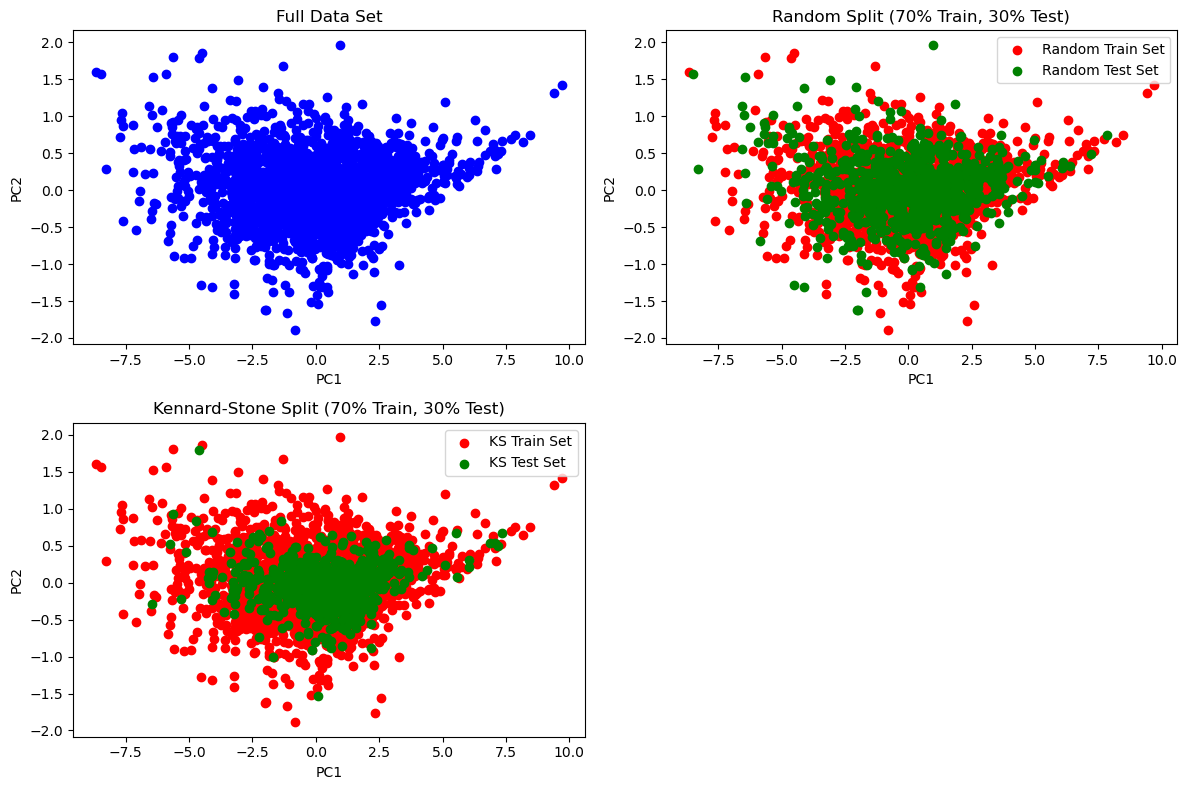

In [12]:
# Step 5: Plot Results
own_functions.plot_pca_comparison(X_full=X,
                                  X_train_random=X_train_random,
                                  X_test_random=X_test_random,
                                  X_train_ks=X_train_ks,
                                  X_test_ks=X_test_ks)

# Basemodel

Baseline model (5 P):
- Develop a global baseline PLSR model using the *calibration dataset* 
  - (entire VNIR range from 500 nm to 2499 nm in steps of 2 nm) 
  - *without* applying any *spectral* *preprocessing*. 
- The target variable is soil organic carbon (SOC). 
- Perform *internal optimization* to *determine* the *optimal* *number* of *latent* *PLS* *variables* 
  -  *report your selected value*. 
- Apply the optimized model* to the independent test set*. 
  - Compute the validation metrics *(R², RMSE, bias, and RPD)*
  - *visualize* the results in a *scatter* *plot* (observed vs. predicted values) 
  - and assess the model's performance.

## Finding optimal number of commponents

In [13]:
import own_functions

Rough Optimization:   0%|          | 0/7 [00:00<?, ?it/s]

Fine Tuning:   0%|          | 0/21 [00:00<?, ?it/s]

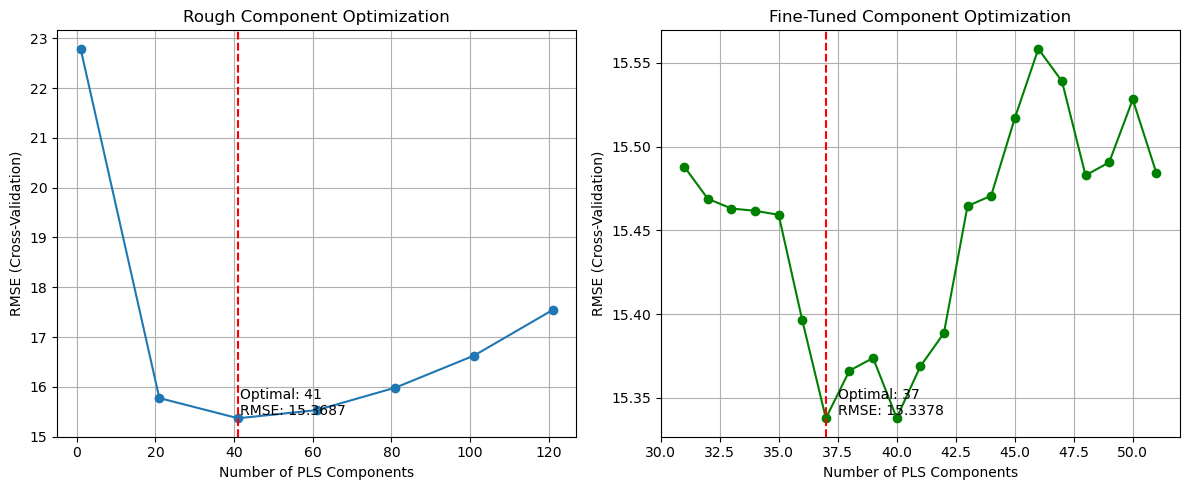

In [48]:
plsr_base_components = own_functions.optimize_pls_components(X_train=X_train_random, 
                                      y_train=y_train_random,
                                      max_components=140,
                                      step=20,
                                      fine_tune=True,
                                      show_progress=True,
                                      plot_results=True
                                      )

## Evaluating Base Model

In [49]:
import own_functions

Root Mean Squared Error (RMSE): 12.9166
R²: 0.6305
Bias: -0.1174
RPD: 1.6451


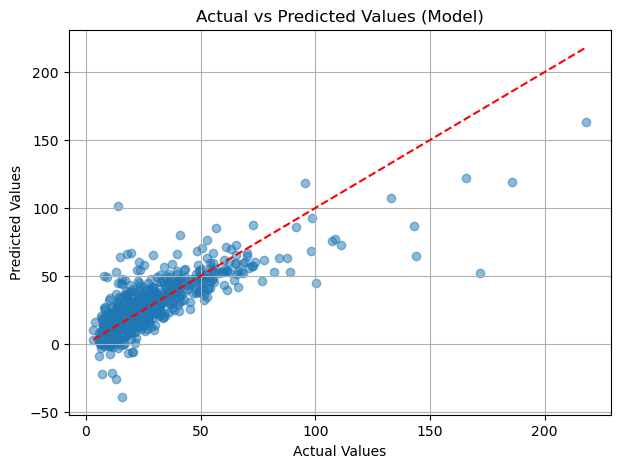

In [50]:
plsr_base_model = PLSRegression(n_components=plsr_base_components["optimal_n"])
plsr_base_model.fit(X_train_random, y_train_random)

plsr_base_eval = own_functions.evaluate_model(plsr_base_model,
                             X_test=X_test_random,
                             y_test=y_test_random,
                             print_metrics=True,
                             show_plot=True
                             )

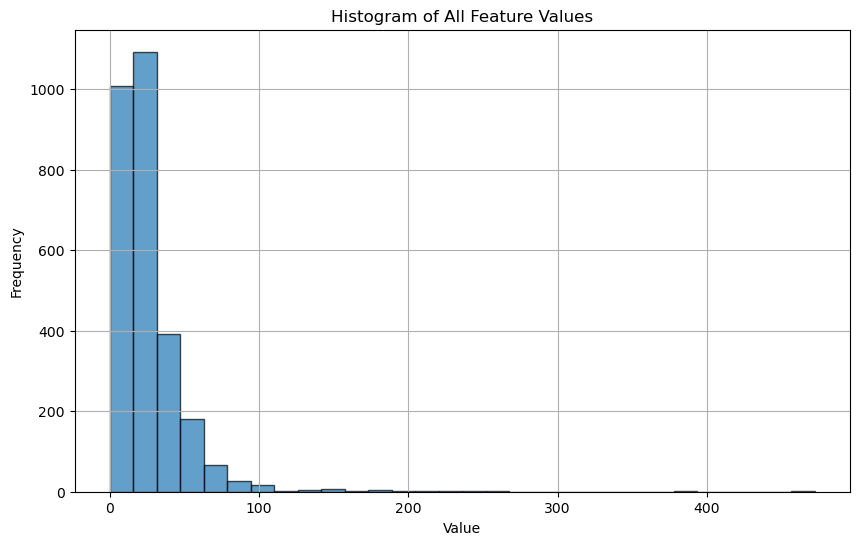

In [51]:
all_values = y.flatten()

# Plot histogram of all feature values
plt.figure(figsize=(10, 6))
plt.hist(all_values, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of All Feature Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Model Improvement Strategies (5 P per strategy):
- Develop and evaluate three distinct strategies to improve the baseline model, 
  - using the **same independent test set for validation**. 
- For each strategy, report the validation metrics
    - (R², RMSE, bias, and RPD), 
    - visualize the best result in a scatter plot (observed vs.predicted values) 
    - assess the performance of these alternative models. 
    - Use the same independent test set for all strategies to ensure that validation metrics are directly comparable.


IMPORTANT: Testing two or more spectral preprocessing methods is considered one
strategy, not multiple strategies. Similarly, testing one or more alternative regression
algorithms counts as one strategy, not multiple.

## Varying Preprocessing Strategy

### Savitzgy-Golay

In [54]:
#TODO: Is scaling necessary?

# Applying Savitzky-Golay filter to calibration and test data
X_train_random_sg = own_functions.apply_savitzky_golay(X_train_random, window_length=41, polyorder=4, deriv=0, delta=2)
X_test_random_sg = own_functions.apply_savitzky_golay(X_test_random, window_length=41, polyorder=4, deriv=0, delta=2)

# Standardize data
scaler_random_sg = StandardScaler()
X_train_random_sg_scaled = scaler_random_sg.fit_transform(X_train_random_sg)
X_test_random_sg_scaled = scaler_random_sg.transform(X_test_random_sg)


# Plot original and filtered data


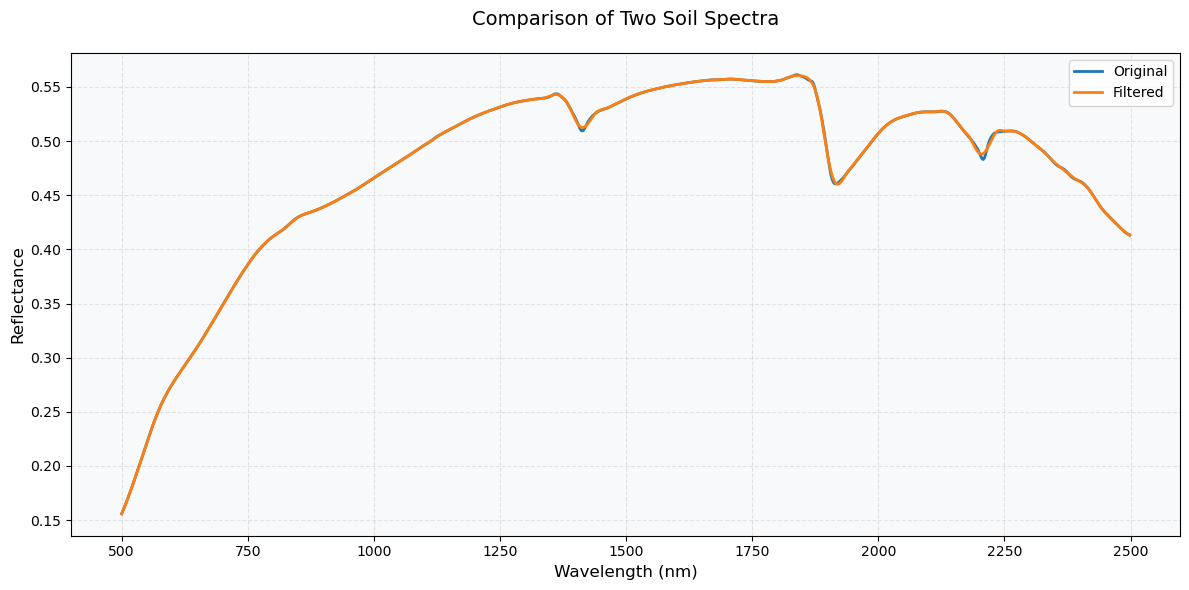

In [55]:
def plot_spectra_comparison(spectrum1, spectrum2, wavelengths=None, labels=None, title="Spectral Comparison"):
    """
    Create a comparison plot of two spectra.
    
    Args:
        spectrum1: First spectrum data
        spectrum2: Second spectrum data
        wavelengths: X-axis values (optional)
        labels: Tuple of (label1, label2) for legend
        title: Plot title
    """
    import matplotlib.pyplot as plt
    
    # Create figure and axis
    plt.figure(figsize=(12, 6))
    
    # Generate x-axis values if not provided
    if wavelengths is None:
        wavelengths = range(len(spectrum1))
    
    # Set default labels if not provided
    if labels is None:
        labels = ('Spectrum 1', 'Spectrum 2')
    
    # Plot spectra
    plt.plot(wavelengths, spectrum1, label=labels[0], linewidth=2)
    plt.plot(wavelengths, spectrum2, label=labels[1], linewidth=2)
    
    # Customize plot
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel('Wavelength (nm)', fontsize=12)
    plt.ylabel('Reflectance', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    
    # Add a subtle background color
    plt.gca().set_facecolor('#f8f9fa')
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


plot_spectra_comparison(
    X_train_random[121], 
    X_train_random_sg[121],
    wavelengths=range(500, 2500, 2),  # Assuming 500-2499nm in 2nm steps
    labels=('Original', 'Filtered'),
    title='Comparison of Two Soil Spectra'
)


Rough Optimization:   0%|          | 0/5 [00:00<?, ?it/s]

Fine Tuning:   0%|          | 0/21 [00:00<?, ?it/s]

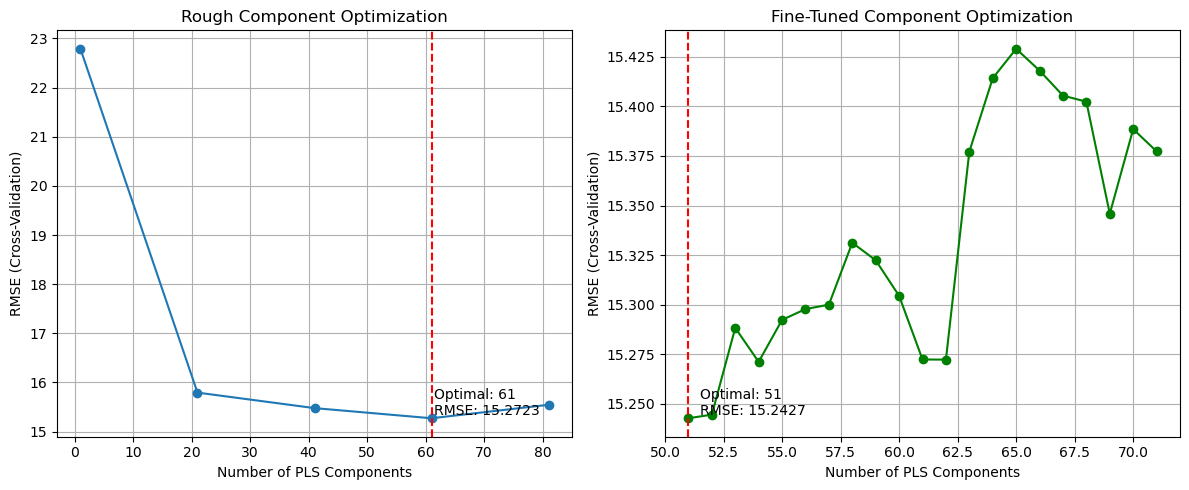

In [56]:
plsr_sgolay_components = own_functions.optimize_pls_components(X_train=X_train_random_sg_scaled, 
                                      y_train=y_train_random,
                                      max_components=100,
                                      step=20,
                                      fine_tune=True,
                                      show_progress=True,
                                      plot_results=True
                                      )

Root Mean Squared Error (RMSE): 12.5479
R²: 0.6513
Bias: 0.0164
RPD: 1.6935


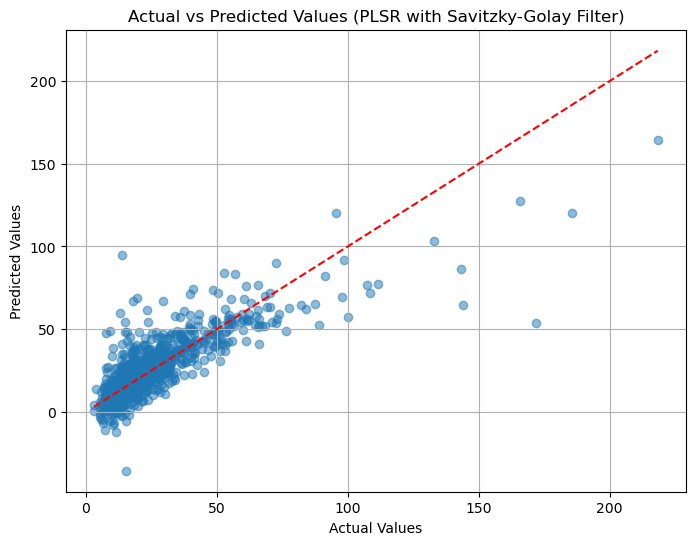

In [57]:
plsr_sg_model = PLSRegression(n_components=plsr_sgolay_components["optimal_n"])
plsr_sg_model.fit(X_train_random_sg_scaled, y_train_random)

plsr_sg_eval = own_functions.evaluate_model(plsr_sg_model,
                             X_test=X_test_random_sg_scaled,
                             y_test=y_test_random,
                             print_metrics=True,
                             show_plot=True,
                             plot_kwargs={'model_name': 'PLSR with Savitzky-Golay Filter',
                                          'figsize': (8, 6)}
                             )

### Standard Normal Variate

In [25]:
import own_functions

In [58]:
# Applying Savitzky-Golay filter to calibration and test data
X_train_ks_snv = own_functions.standard_normal_variate(X_train_ks)
X_test_ks_snv = own_functions.standard_normal_variate(X_test_ks)

# Standardize data
scaler_ks_snv = StandardScaler()
X_train_ks_snv_scaled = scaler_ks_snv.fit_transform(X_train_ks_snv)
X_test_ks_snv_scaled = scaler_ks_snv.transform(X_test_ks_snv)

Rough Optimization:   0%|          | 0/5 [00:00<?, ?it/s]

Fine Tuning:   0%|          | 0/21 [00:00<?, ?it/s]

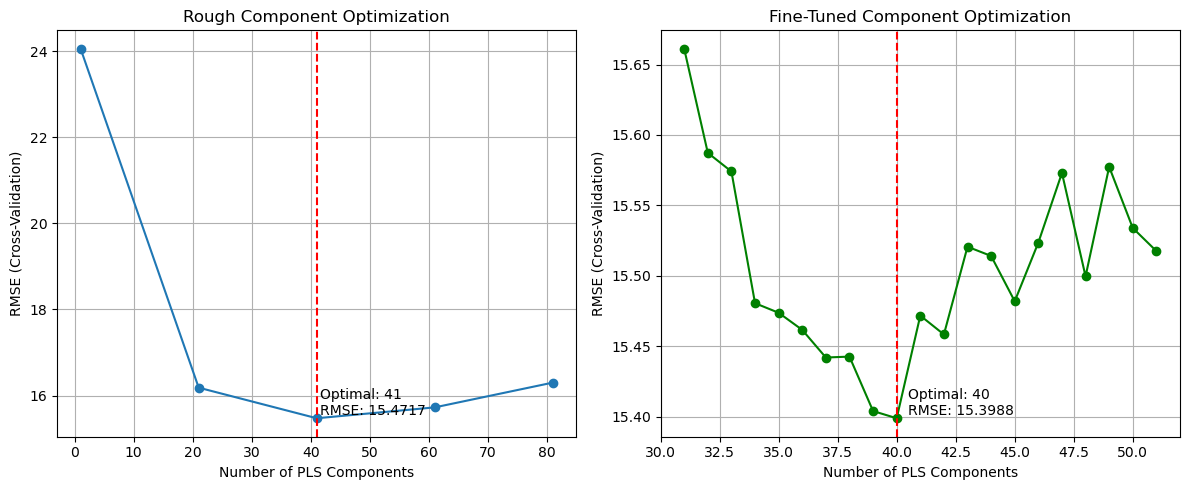

In [59]:
plsr_snv_components = own_functions.optimize_pls_components(X_train=X_train_ks_snv_scaled, 
                                      y_train=y_train_ks,
                                      max_components=100,
                                      step=20,
                                      fine_tune=True,
                                      show_progress=True,
                                      plot_results=True
                                      )

Root Mean Squared Error (RMSE): 10.1517
R²: 0.6485
Bias: 0.3009
RPD: 1.6867


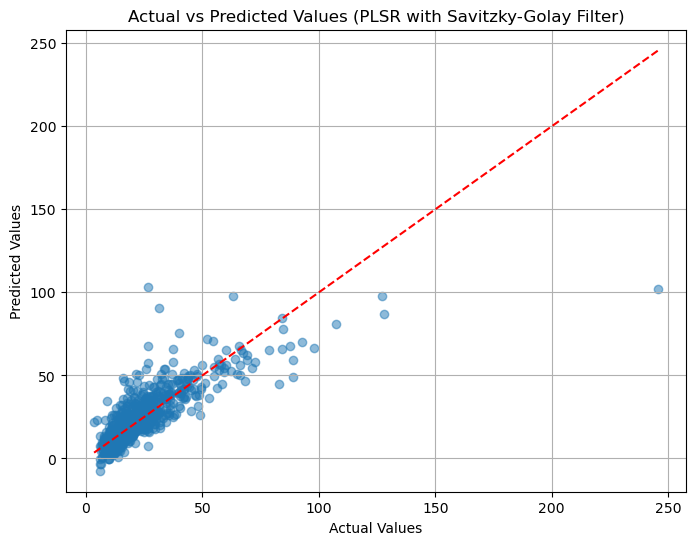

In [60]:
plsr_snv_model = PLSRegression(n_components=plsr_snv_components["optimal_n"])
plsr_snv_model.fit(X_train_ks_snv_scaled, y_train_ks)

plsr_snv_eval = own_functions.evaluate_model(plsr_snv_model,
                             X_test=X_test_ks_snv_scaled,
                             y_test=y_test_ks,
                             print_metrics=True,
                             show_plot=True,
                             plot_kwargs={'model_name': 'PLSR with Savitzky-Golay Filter',
                                          'figsize': (8, 6)}
                             )

## Testing Different Models

### Pytorch LSTM

In [ ]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward pass through LSTM layer
        out, _ = self.lstm(x, (h0, c0))
        
        # Select the last time step
        out = out[:, -1, :]

        # Forward pass through fully connected layer
        out = self.fc(out)
        return out
    
    def predict(self, X):
        self.eval()  # Set to evaluation mode
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            predictions = self(X_tensor.unsqueeze(1)).squeeze()
        return predictions.numpy()

In [ ]:
def train_and_evaluate_lstm(X_train, X_test, y_train, y_test, hidden_size=256, num_layers=5, 
                          num_epochs=500, learning_rate=0.005):
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    
    # Initialize model
    input_size = X_train.shape[1]
    model = LSTMModel(input_size, hidden_size, 1, num_layers)
    
    # Training setup
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X_train_tensor.unsqueeze(1))
        loss = criterion(outputs.squeeze(), y_train_tensor)
        
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor.unsqueeze(1)).squeeze()
        test_loss = criterion(predictions, y_test_tensor)
        
        # Convert to numpy
        y_pred = predictions.numpy()
        y_test = y_test_tensor.numpy()
        
        
        print(f'Test Loss: {test_loss.item():.4f}')
        
    return model, y_pred, y_test

In [ ]:
# Standardize data using training data for fitting
ks_scalar = StandardScaler()
X_train_ks_scaled = ks_scalar.fit_transform(X_train_ks)
X_test_ks_scaled = ks_scalar.transform(X_test_ks)

In [ ]:
# Training base LSTM model
LSTM_base_model, y_pred_lstm, y_test_tensor = train_and_evaluate_lstm(X_train_ks_scaled, X_test_ks_scaled, y_train_ks, y_test_ks,
                                                      hidden_size=256, 
                                                      num_layers=5, 
                                                      num_epochs=150, 
                                                      learning_rate=0.1)


In [ ]:
# After training your model:
LSTM_base_eval = own_functions.evaluate_model(
    model=LSTM_base_model,
    X_test=X_test_ks, 
    y_test=y_test_ks,
    print_metrics=True,
    show_plot=True,
    plot_kwargs={'model_name': 'LSTM', 'figsize': (8, 6)}
)

### LSTM with PLSR components

In [ ]:
pls = PLSRegression(n_components=plsr_base_components["optimal_n"])
pls.fit(X_train_ks_scaled, y_train_ks)


# Fit PLSR on the training data and transform the training set
X_train_pls, _ = plsr_base_model.fit_transform(X_train_ks_scaled, y_train_ks)

# Transform the test set using the fitted model (trained on the training set)
X_test_pls = plsr_base_model.transform(X_test_ks)

In [ ]:
#TODO: Setting num_layers from 5 to 3 improved model
LSTM_plsr_model, y_pred_lstm_plsr, y_test_plsr = train_and_evaluate_lstm(X_train_pls, X_test_pls, y_train_ks, y_test_ks,
                                                                        hidden_size=256, 
                                                                        num_layers=5, 
                                                                        num_epochs=500, 
                                                                        learning_rate=0.001)

In [ ]:
# After training your model:
own_functions.evaluate_model(
    model=LSTM_plsr_model,
    X_test=X_test_pls, 
    y_test=y_test_ks,
    print_metrics=True,
    show_plot=True,
    plot_kwargs={'model_name': 'LSTM', 'figsize': (8, 6)}
)

# Testing

##  Random set  PLSR LSTM 

In [69]:
X_train_random

# do snv
X_train_random_snv = own_functions.standard_normal_variate(X_train_random)
X_test_random_snv = own_functions.standard_normal_variate(X_test_random)

# Standardize data using training data for fitting
random_scalar = StandardScaler()
X_train_random_scaled = random_scalar.fit_transform(X_train_random_snv)
X_test_random_scaled = random_scalar.transform(X_test_random_snv)

In [70]:
pls = PLSRegression(n_components=plsr_base_components["optimal_n"])
pls.fit(X_train_random_snv, y_train_random)


# Fit PLSR on the training data and transform the training set
X_train_pls, _ = plsr_base_model.fit_transform(X_train_random_snv, y_train_random)

# Transform the test set using the fitted model (trained on the training set)
X_test_pls = plsr_base_model.transform(X_test_random_scaled)

In [ ]:
#TODO: Setting num_layers from 5 to 3 improved model
LSTM_plsr_model, y_pred_lstm_plsr, y_test_plsr = train_and_evaluate_lstm(X_train_pls, X_test_pls, y_train_random, y_test_random,
                                                                        hidden_size=256, 
                                                                        num_layers=3, 
                                                                        num_epochs=500, 
                                                                        learning_rate=0.01)

In [ ]:
# After training your model:
own_functions.evaluate_model(
    model=LSTM_plsr_model,
    X_test=X_test_pls, 
    y_test=y_test_ks,
    print_metrics=True,
    show_plot=True,
    plot_kwargs={'model_name': 'LSTM', 'figsize': (8, 6)}
)

## Testing original deepak lstm code

In [ ]:


# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_pls, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_random, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_pls, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_random, dtype=torch.float32)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward pass through LSTM layer
        out, _ = self.lstm(x, (h0, c0))
        # Select the last time step
        out = out[:, -1, :]
        # Forward pass through fully connected layer
        out = self.fc(out)
        return out

# Hyperparameters
input_size = X_test_pls.shape[1]  # Number of features after PLSR
hidden_size = 256
output_size = 1  # For regression
num_layers = 5
num_epochs = 3000
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train_tensor.unsqueeze(1))  # Add sequence dimension
    loss = criterion(outputs.squeeze(), y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    # Make predictions on the test set
    predictions = model(X_test_tensor.unsqueeze(1)).squeeze()
    
    # Calculate test loss
    test_loss = criterion(predictions, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')
    
    # Convert predictions and y_test to numpy arrays
    y_pred_np = predictions.numpy()
    y_test_np = y_test_tensor.numpy()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_np))
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    
    # Calculate correlation coefficient
    correlation, _ = pearsonr(y_test_np, y_pred_np)
    print(f'Correlation coefficient: {correlation:.4f}')
    
    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test_np, y_pred_np, alpha=0.5)
    plt.plot([min(y_test_np), max(y_test_np)], [min(y_test_np), max(y_test_np)], color='red', linestyle='--')  # Perfect prediction line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values (PLSR + LSTM)')
    plt.grid(True)
    plt.show()

### Test validation error optim

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers with dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout)
        
        # Additional dropout layers
        self.dropout1 = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward pass through LSTM layer
        out, _ = self.lstm(x, (h0, c0))
        # Select the last time step
        out = out[:, -1, :]
        # Forward pass through fully connected layer
        out = self.fc(out)
        return out
        
        return out
    
    def predict(self, X):
        self.eval()  # Set to evaluation mode
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            predictions = self(X_tensor.unsqueeze(1)).squeeze()
        return predictions.numpy()

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
            self.counter = 0

def train_and_evaluate_lstm(X_train, X_val, X_test, y_train, y_val, y_test, 
                          hidden_size=256, num_layers=5, num_epochs=500, 
                          learning_rate=0.005, patience=7):
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    
    # Initialize model and training components
    input_size = X_train.shape[1]
    model = LSTMModel(input_size, hidden_size, 1, num_layers)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    early_stopping = EarlyStopping(patience=patience)
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'best_epoch': 0
    }
    
    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        train_outputs = model(X_train_tensor.unsqueeze(1))
        train_loss = criterion(train_outputs.squeeze(), y_train_tensor)
        train_loss.backward()
        optimizer.step()
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor.unsqueeze(1))
            val_loss = criterion(val_outputs.squeeze(), y_val_tensor)
            
        # Store losses
        history['train_loss'].append(train_loss.item())
        history['val_loss'].append(val_loss.item())
        
        # Early stopping check
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f'Early stopping triggered at epoch {epoch + 1}')
            history['best_epoch'] = epoch - patience
            break
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss.item():.4f}, '
                  f'Val Loss: {val_loss.item():.4f}')
    
    # Load best model
    model.load_state_dict(early_stopping.best_model)
    
    # Final evaluation
    model.eval()
    with torch.no_grad():
        final_predictions = model(X_test_tensor.unsqueeze(1)).squeeze()
        test_loss = criterion(final_predictions, y_test_tensor)
        
        # Convert to numpy for metrics
        y_pred = final_predictions.numpy()
        y_true = y_test_tensor.numpy()
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        bias = np.mean(y_pred - y_true)
        rpd = np.std(y_true) / rmse
        
        metrics = {
            'test_loss': test_loss.item(),
            'rmse': rmse,
            'r2': r2,
            'bias': bias,
            'rpd': rpd
        }
        
        print("\nFinal Test Metrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
    
    return model, history, metrics

In [ ]:
# First split training data into train and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_ks_scaled, y_train_ks, 
                                                             test_size=0.2, 
                                                             random_state=42)

# Training enhanced LSTM model
LSTM_base_model, history, metrics = train_and_evaluate_lstm(
    X_train=X_train_final,
    X_val=X_val,
    X_test=X_test_ks_scaled,
    y_train=y_train_final,
    y_val=y_val,
    y_test=y_test_ks,
    hidden_size=256,
    num_layers=5,
    num_epochs=500,
    learning_rate=0.01,
    patience=30  # Early stopping patience
)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.axvline(x=history['best_epoch'], color='r', linestyle='--', label='Best Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Get predictions for test set
y_pred_lstm = LSTM_base_model.predict(X_test_ks_scaled)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_ks, y_pred_lstm, alpha=0.5)
plt.plot([min(y_test_ks), max(y_test_ks)], 
         [min(y_test_ks), max(y_test_ks)], 
         color='red', 
         linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('LSTM Model: Actual vs Predicted Values')
plt.grid(True)
plt.show()

# Print metrics
print("\nFinal Model Performance Metrics:")
print(f"R²: {metrics['r2']:.4f}")
print(f"RMSE: {metrics['rmse']:.4f}")
print(f"Bias: {metrics['bias']:.4f}")
print(f"RPD: {metrics['rpd']:.4f}")

### Test autoglone


In [61]:
# AutoGluon Testing
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd


In [78]:

# Convert numpy arrays to DataFrame with wavelength columns
wavelengths = range(500, 2500, 2)  # Your wavelength range
train_df = pd.DataFrame(X_train_random_scaled, columns=range(1, X_train_random_scaled.shape[1] + 1))
test_df = pd.DataFrame(X_test_random_scaled, columns=range(1, X_train_random_scaled.shape[1] + 1))

In [79]:
# Add target variable
train_df['SOC'] = y_train_random
test_df['SOC'] = y_test_random

In [80]:
predictor=TabularPredictor(label='SOC').fit(train_df)

No path specified. Models will be saved in: "AutogluonModels\ag-20250221_201126"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       2.17 GB / 13.86 GB (15.6%)
Disk Space Avail:   34.90 GB / 475.69 GB (7.3%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         :

In [83]:
print(f"predictor path is {predictor.path}")

predictor path is c:\Users\luis_\Desktop\Alles\Uni\Leipzig\WS_24_25\spectroscopy\final_project\soc_modelling\AutogluonModels\ag-20250221_201126


In [81]:
# Show leaderboard
print("\nModel Leaderboard:")
print(predictor.leaderboard(test_df))


Model Leaderboard:
                 model  score_test  score_val              eval_metric  \
0  WeightedEnsemble_L2  -11.955164 -12.267201  root_mean_squared_error   
1      NeuralNetFastAI  -12.010839 -12.308925  root_mean_squared_error   
2             CatBoost  -13.027793 -16.296007  root_mean_squared_error   
3        ExtraTreesMSE  -14.013130 -18.250391  root_mean_squared_error   
4      RandomForestMSE  -14.232233 -17.548403  root_mean_squared_error   
5              XGBoost  -14.341266 -17.407363  root_mean_squared_error   
6       KNeighborsDist  -14.870150 -25.204131  root_mean_squared_error   
7       KNeighborsUnif  -14.997609 -25.681464  root_mean_squared_error   

   pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  \
0        0.231223       0.088967   87.616624                 0.005017   
1        0.099229       0.039878    6.504991                 0.099229   
2        0.127084       0.047920  569.513117                 0.127084   
3        0.231803    

Root Mean Squared Error (RMSE): 11.9552
R²: 0.6835
Bias: -1.3146
RPD: 1.7774


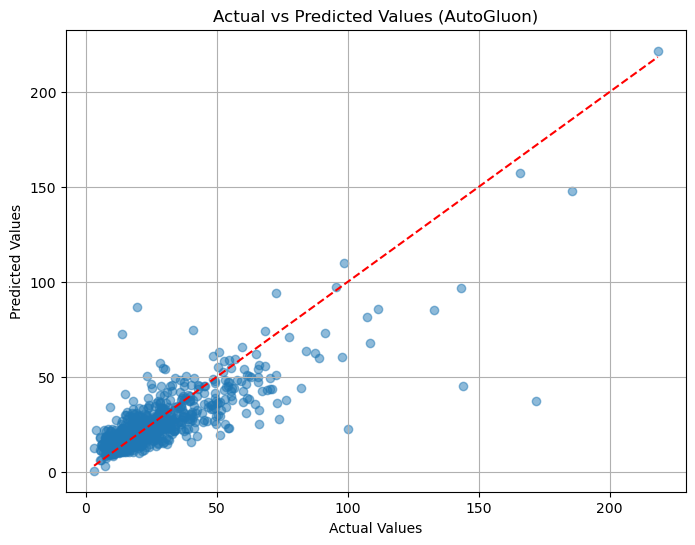

In [82]:
# Get predictions and evaluate
y_pred_auto = predictor.predict(test_df.drop(columns=['SOC']))

# Evaluate using your existing function
autogluon_eval = own_functions.evaluate_model(
    predictor,
    X_test=test_df.drop(columns=['SOC']), 
    y_test=test_df['SOC'],
    print_metrics=True,
    show_plot=True,
    plot_kwargs={'model_name': 'AutoGluon', 'figsize': (8, 6)}
)

# Discussion of Results (5 P):
- Briefly discuss your results and interpret them based on the validation metrics for the
test set. 
- Compare your findings with those of published studies in a similar context.
- Evaluate whether soil VNIR reflectance spectroscopy could serve as a complementary
approach for large-scale soil organic carbon assessment in Earth (system) science.

**Additional Information:**

The length of the discussion section really depends on your results, but as a general guideline, I would expect it to be around one page.

- **Focus on**: 
  - directly comparing your different modeling approaches 
  - interpreting which performed best based on the validation metrics
- If the results are not as good as expected:
  - consider discussing possible reasons and suggesting ways to improve them 
  - (you might find 1-2 examples from the literature helpful here).

- Additionally, you could compare your findings with similar studies that have attempted to model SOC (or related properties) at national or continental scales using spectroscopy—ideally referencing 2-3 relevant publications.

- Finally, reflect on whether and how soil VNIR spectroscopy could contribute to large-scale soil information systems. 
  - This is a more theoretical aspect, and you are free in how you approach this point. 
  - Important aspects to consider might include:
    - a) Model accuracy (What would be considered a good accuracy in this context?)
    - b) Data harmonization (Challenges when combining datasets from different providers)
    - c) Practical usability (Would end users require programming skills, etc.?)

A recent publication that could provide a useful overview is:
Peng et al. (2025): Spectroscopic solutions for generating new global soil information
(Link: https://www.sciencedirect.com/science/article/pii/S2666675825000426)"